In [15]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from PIL import Image
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import time
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom


In [16]:
df = pd.read_csv('df_t.csv')

In [17]:
df_samp= df.sample(frac=0.3)
df_samp.shape

(315, 23)

In [20]:
# Augmenter la limite par défaut (ici, par exemple, fixée à une valeur très élevée)
Image.MAX_IMAGE_PIXELS = None 

def image_prep_fct(df):
    # Définir le chemin d'accès relatif aux images
    base_image_path = "Images/"

    prepared_images = []
    for image_name in df_samp['image']:
        # Construire le chemin complet de l'image
        image_path = os.path.join(base_image_path, image_name)

        # Charger, traiter et prétraiter l'image
        img = load_img(image_path, target_size=(224, 224))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)

    prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct(df_samp)
X = images_np
print(X.shape)

(315, 224, 224, 3)


In [21]:
# Initialisation du LabelEncoder
label_encoder = LabelEncoder()

# Convertir les labels texte en labels numériques
y_encoded = label_encoder.fit_transform(df_samp['category'])

# Conversion des labels numériques en one-hot encoding
y = to_categorical(y_encoded)

print(y.shape)

(315, 7)


In [22]:
X_temp, X_train, y_temp, y_train = train_test_split(X, y, test_size=0.7, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [23]:
X_train.shape, X_val.shape, X_test.shape

((221, 224, 224, 3), (47, 224, 224, 3), (47, 224, 224, 3))

In [24]:
def create_model_fct() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [26]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                      

In [27]:
# Enregistrez l'heure de début
start_time = time.time()

# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=20, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

# Enregistrez l'heure de fin
end_time = time.time()

# Calculez et affichez la durée
duration = end_time - start_time
print(f"Le temps d'entraînement est de: {duration:.2f} secondes.")

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 1.9496 - accuracy: 0.2036  
Epoch 1: val_loss improved from inf to 1.58736, saving model to .\model1_best_weights.h5
4/4 [==============================] - 307s 75s/step - loss: 1.9496 - accuracy: 0.2036 - val_loss: 1.5874 - val_accuracy: 0.6383
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 1.6957 - accuracy: 0.3575  
Epoch 2: val_loss improved from 1.58736 to 1.37358, saving model to .\model1_best_weights.h5
4/4 [==============================] - 305s 80s/step - loss: 1.6957 - accuracy: 0.3575 - val_loss: 1.3736 - val_accuracy: 0.6809
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 1.4713 - accuracy: 0.5385  
Epoch 3: val_loss improved from 1.37358 to 1.24437, saving model to .\model1_best_weights.h5
4/4 [==============================] - 424s 113s/step - loss: 1.4713 - accuracy: 0.5385 - val_loss: 1.2444 - val_accuracy: 0.7447
Epoch 4/20
4/4 [==============================] - ETA: 

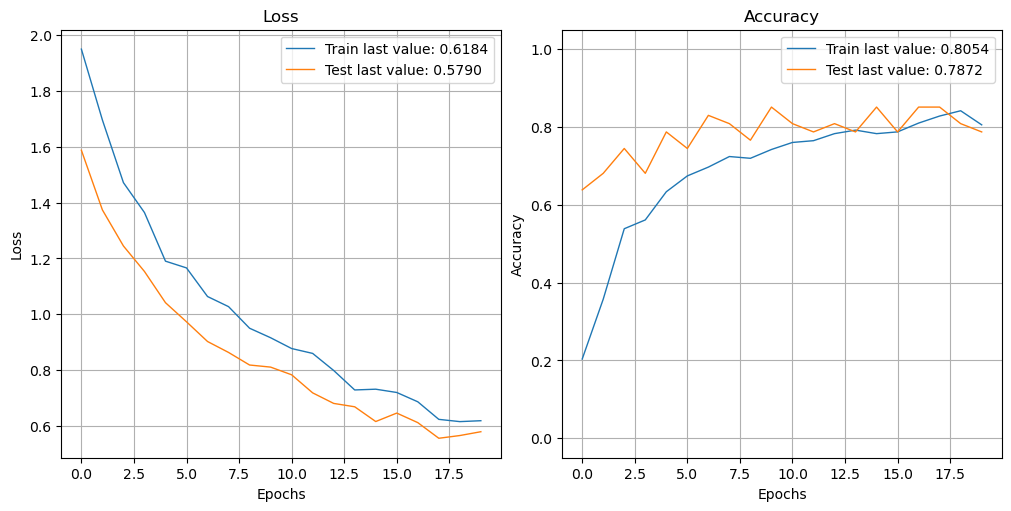

In [28]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [29]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Loss     :  {:.4f}".format(loss))
print("Validation Accuracy :  {:.4f}".format(accuracy))

print("")

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Loss           :  {:.4f}".format(loss))
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Loss     :  0.5555
Validation Accuracy :  0.8511

Test Loss           :  1.2635
Test Accuracy       :  0.5957


In [30]:
df_rec = {
    "Modèle": ["Perceptron multicouche", "Modèle simple CNN", "VGG16 + Transfer Learning", "VGG16 + Transfer Learning + DATA AUGMENTATION"],
    "Nb_Epochs": [6, 9, 15, 20],
    "test_loss": [2072.2900, 1.9006, 1.335, 0.7200],
    "test_accuracy": [0.3544, 0.3418, 0.8165, 0.7722],
    "temps (s)": [21.11, 162.67, 1722.07, 368.70]
}

df = pd.DataFrame(df_rec)
df.set_index('Modèle', inplace=True)

def highlight_cells(col):
    # Dictionnaire pour mapper les colonnes aux fonctions appropriées
    mappers = {
        'Nb_Epochs': min,
        'test_loss': min,
        'test_accuracy': max,
        'temps (s)': min
    }
    
    if col.name in mappers:
        criteria = mappers[col.name](col)
        return ['background-color: green' if v == criteria else '' for v in col]
    return [''] * len(col)

styled_df = df.style.apply(highlight_cells)
styled_df


,Nb_Epochs,test_loss,test_accuracy,temps (s)
Modèle,,,,
Perceptron multicouche,6,2072.290000,0.354400,21.110000
Modèle simple CNN,9,1.900600,0.341800,162.670000
VGG16 + Transfer Learning,15,1.335000,0.816500,1722.070000
VGG16 + Transfer Learning + DATA AUGMENTATION,20,0.720000,0.772200,368.700000
